## 0. 参数配置

In [17]:
import os
import sys
BASE_DIR = os.getcwd()
sys.path.append(os.path.join(BASE_DIR, '..'))
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from models.deeplab import DeepLabV3Plus
from utils.utils import *

physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print('TensorFlow', tf.__version__)
log_dir = create_logdir(BASE_DIR)

TensorFlow 2.3.0
make dir： /mnt/cd1/home/teacher/notebooks/cv_project_2days/image_segmentation/deeplabv3+-cityscapes/logs/08-24_11-47


In [18]:
# step0：配置参数
# root_dir = r"F:\A_china_telecom\03-3rd\02-code\deeplabv3+-cityscapes\data\cityscapes"   # must be reorder dirs
root_dir = "/home/teacher/notebooks/cv_project_2days/object_detection/data/cityspaces_reorder" 
batch_size = 8  # 8 for linux
H, W = 512, 512
num_classes = 34
MAX_EPOCH = 80  # 300
lr_init = 1e-4
decay_rate = 0.99
debug_img_num = 0
path_save_weight = os.path.join(log_dir, "model_weights_best.h5")

## 1. 数据集制作

In [19]:
# step1：数据集制作
img_info = get_img_lst(root_dir, debug_img_num)
image_list, mask_list, val_image_list, val_mask_list = img_info

train_dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
train_dataset = train_dataset.shuffle(buffer_size=128).apply(
    tf.data.experimental.map_and_batch(map_func=load_data,  # 实现数据预处理功能
                                       batch_size=batch_size,
                                       num_parallel_calls=tf.data.experimental.AUTOTUNE,
                                       drop_remainder=True))
train_dataset = train_dataset.repeat().prefetch(tf.data.experimental.AUTOTUNE)  # 将整个数据重复多次，用于处理Epoch

val_dataset = tf.data.Dataset.from_tensor_slices((val_image_list, val_mask_list))
val_dataset = val_dataset.apply(
    tf.data.experimental.map_and_batch(map_func=load_data,
                                       batch_size=batch_size,
                                       num_parallel_calls=tf.data.experimental.AUTOTUNE,
                                       drop_remainder=True))
val_dataset = val_dataset.repeat().prefetch(tf.data.experimental.AUTOTUNE)

Found 2975 training images
Found 500 validation images


In [20]:
print("训练集图片有:{}张, \n第一张图片在:{} \n验证集有:{}张，\n第一张图片在:{}".format(
    len(image_list), image_list[0], len(val_image_list), val_image_list[0]))

训练集图片有:2975张, 
第一张图片在:/home/teacher/notebooks/cv_project_2days/object_detection/data/cityspaces_reorder/dataset/train_images/aachen_000000_000019_leftImg8bit.png 
验证集有:500张，
第一张图片在:/home/teacher/notebooks/cv_project_2days/object_detection/data/cityspaces_reorder/dataset/val_images/frankfurt_000000_000294_leftImg8bit.png


/home/teacher/notebooks/cv_project_2days/object_detection/data/cityspaces_reorder/dataset/train_masks/aachen_000000_000019_gtFine_labelIds.png
7
26
mask 最大值33，最小值0


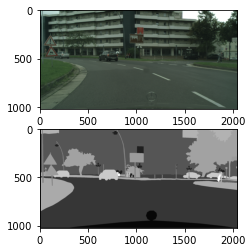

In [21]:
img = Image.open((image_list[0]))
msk = Image.open((mask_list[0]))
plt.subplot(211).imshow(img)
plt.subplot(212).imshow(msk, cmap="gray")

msk_arr = np.array(msk)
print((mask_list[0]))
print(msk_arr[600, 1000])  # 7 road 1000，600对应的像素点
print(msk_arr[480, 700])  #  26  car
print("mask 最大值{}，最小值{}".format(msk_arr.max(), msk_arr.min())) # 这里就是第33类

## 2. 定义优化策略

In [22]:
# step2：损失函数、优化器、学习率调整策略设置

loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
epoch_size = len(image_list) // batch_size
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=lr_init, decay_steps=epoch_size, decay_rate=decay_rate, staircase=True)
optimizer = tf.optimizers.Adam(learning_rate=lr_schedule)

## 3. 模型搭建、编译

In [23]:
# step3：模型搭建、编译
model = DeepLabV3Plus(H, W, num_classes)
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.momentum = 0.9997
        layer.epsilon = 1e-5
    elif isinstance(layer, tf.keras.layers.Conv2D):
        layer.kernel_regularizer = tf.keras.regularizers.l2(1e-4)

model.compile(loss=loss, optimizer=optimizer,  metrics=['accuracy'])

*** Building DeepLabv3Plus Network ***


ValueError: No such layer: activation_39.

## 4. 训练模型

In [8]:
# step4：训练模型
tb = TensorBoard(log_dir='logs', write_graph=True, update_freq='batch')
mc = ModelCheckpoint(mode='min', filepath=path_save_weight, monitor='val_loss', save_best_only='True',
                     save_weights_only='True', verbose=1)
callbacks = [mc, tb]

model.fit(train_dataset,
          steps_per_epoch=len(image_list) // batch_size,
          epochs=MAX_EPOCH,
          validation_data=val_dataset,
          validation_steps=len(val_image_list) // batch_size,
          callbacks=callbacks)

Epoch 1/80


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[8,512,512,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node DeepLabV3_Plus/activation_decoder_2_upsample/resize/ResizeBilinear (defined at /mnt/cd1/home/teacher/notebooks/cv_project_2days/image_segmentation/deeplabv3+-cityscapes/models/deeplab.py:13) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Func/cond_1/then/_10/input/_34/_28]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[8,512,512,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node DeepLabV3_Plus/activation_decoder_2_upsample/resize/ResizeBilinear (defined at /mnt/cd1/home/teacher/notebooks/cv_project_2days/image_segmentation/deeplabv3+-cityscapes/models/deeplab.py:13) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_15580]

Errors may have originated from an input operation.
Input Source operations connected to node DeepLabV3_Plus/activation_decoder_2_upsample/resize/ResizeBilinear:
 DeepLabV3_Plus/activation_decoder_2/Relu (defined at <ipython-input-8-22243901b2a9>:7)

Input Source operations connected to node DeepLabV3_Plus/activation_decoder_2_upsample/resize/ResizeBilinear:
 DeepLabV3_Plus/activation_decoder_2/Relu (defined at <ipython-input-8-22243901b2a9>:7)

Function call stack:
train_function -> train_function
